# Neural Networks Learning

Week5のニューラルネットワークの学習について

In [1]:
import math
import numpy as np
from scipy import optimize
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Visualizing the data

In [2]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)   # 図を大きく表示

In [3]:
dataset = loadmat('ex4data1.mat')
X = dataset['X']
y = dataset['y']

X.shape, y.shape

((5000, 400), (5000, 1))

In [4]:
def display_data(images, labels, indexes):
    m = len(indexes)
    rows = math.floor(math.sqrt(m))
    columns = math.ceil(m / rows)

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.7)

    for row in range(rows):
        for col in range(columns):
            i = row * columns + col
            if i >= m: break
            index = indexes[i];
            ax = fig.add_subplot(rows, columns, i+1)
            ax.axis('off')
            ax.set_title(labels[index])
            ax.imshow(images[index].reshape(20,20).T, cmap = plt.get_cmap('gray'))

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


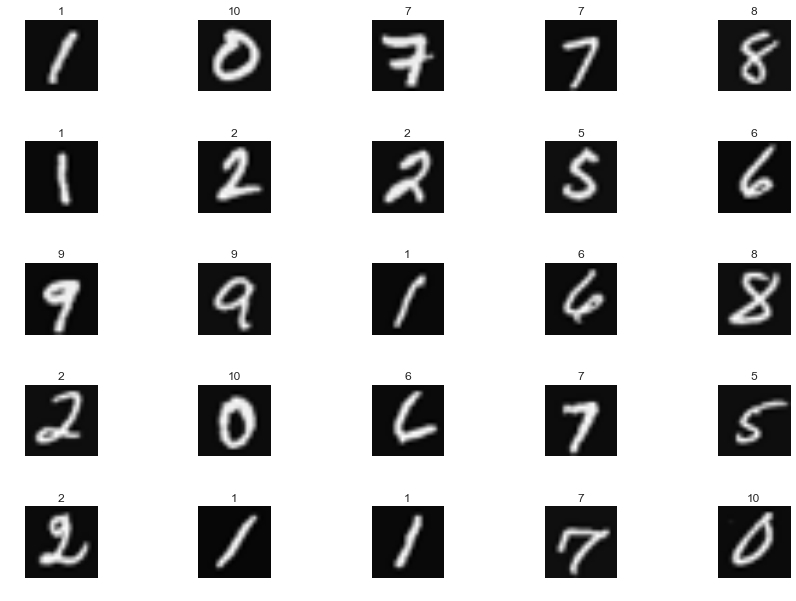

In [5]:
labels = y.ravel().tolist()
indexes = np.random.randint(0, len(labels), (25, 1))
display_data(X, labels, indexes)
plt.savefig('week05_dataset.png')

## Model representation

In [6]:
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

theta1.shape, theta2.shape

((25, 401), (10, 26))

## Feedforward and cost function

In [7]:
%run 'nn_learning.py'

In [8]:
num_labels = len(np.unique(y))
res1 = compute_cost(theta1, theta2, num_labels, X, y, 0.)
res2 = compute_cost(theta1, theta2, num_labels, X, y, 1.)
res3 = compute_cost(theta1, theta2, num_labels, X, y, 3.)

res1[0], res2[0], res3[0]

J = 0.287629165161
J = 0.383769859091
J = 0.57605124695


(0.28762916516131892, 0.38376985909092365, 0.5760512469501331)

## Backpropagation

In [9]:
sigmoid_gradient(np.array([-1.0, -0.5, 0, 0.5, 1.0]))

array([ 0.19661193,  0.23500371,  0.25      ,  0.23500371,  0.19661193])

In [10]:
initial_theta1 = rand_initialize_weights(theta1.shape)
initial_theta2 = rand_initialize_weights(theta2.shape)
theta1, theta2 = optimize_thetas(initial_theta1, initial_theta2, num_labels, X, y, 1.)

J = 7.15148898946
J = 7.15148898946
J = 4.43847306716
J = 3.30868515521
J = 3.25286592052
J = 3.24540825358
J = 3.21919718873
J = 3.16988638256
J = 3.01597644905
J = 2.82359265192
J = 2.65913293761
J = 2.38969940619
J = 2.1807663086
J = 2.06519795481
J = 1.92519873664
J = 1.74362599974
J = 1.6410730681
J = 1.53867492257
J = 1.4976920451
J = 1.44877302644
J = 1.34775989019
J = 1.27838578153
J = 1.18859625532
J = 1.14071239494
J = 1.07964621322
J = 1.04970250123
J = 1.01008662709
J = 0.98606736548
J = 0.94210261159
J = 0.916729165899
J = 0.866392274096
J = 0.854964358016
J = 0.828341038957
J = 0.820806598779
J = 0.801169561239
J = 0.79506758353
J = 0.775716843346
J = 0.760287703565
J = 0.747726917682
J = 0.721685703938
J = 0.711003235068
J = 0.695107515275
J = 0.690300286642
J = 0.677168681325
J = 0.674218464033
J = 0.667366466639
J = 0.655172530875
J = 0.650967738151
J = 0.641861440822
J = 0.638651516938
J = 0.630705086653
J = 0.628852464519
J = 0.623451542203
J = 0.621239845482
J = 0.6

In [11]:
preds = predict(theta1, theta2, X)
pred_classes = np.array([p['class'] for p in preds]).reshape(len(preds), 1)
compute_train_accuracy(pred_classes, y)

96.899999999999991

In [12]:
corrects = (np.where(pred_classes == y))[0]
mistakes = (np.where(pred_classes != y))[0]

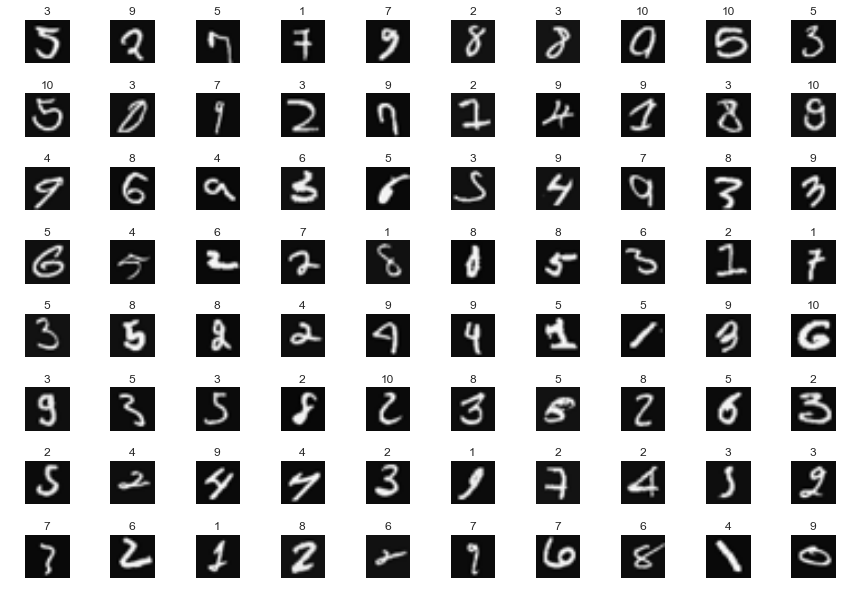

In [13]:
labels = pred_classes.ravel().tolist()
display_data(X, labels, np.random.permutation(mistakes)[0:80])

(array([  9.,  13.,  20.,  22.,  21.,  21.,  12.,  12.,  11.,  14.]),
 array([ 0.0309472 ,  0.12457763,  0.21820806,  0.3118385 ,  0.40546893,
         0.49909936,  0.5927298 ,  0.68636023,  0.77999066,  0.8736211 ,
         0.96725153]),
 <a list of 10 Patch objects>)

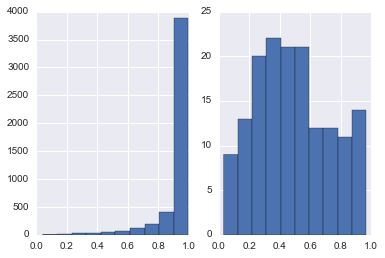

In [14]:
df = pd.DataFrame(data=preds)

plt.rcParams['figure.figsize'] = (6.0, 4.0)
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.hist(df.ix[corrects].value)
ax = fig.add_subplot(1,2,2)
ax.hist(df.ix[mistakes].value)

In [15]:
(np.identity(num_labels)[y-1,:])[:,0,:].shape

(5000, 10)